In [23]:
one_M = 1e6 
one_B = 1e9

max_lr = 6e-4
min_lr = max_lr*0.1

In [24]:
warmup_tokens = 375*one_M

In [27]:
batch_size = 2**19
max_steps = 17167
warmup_steps = warmup_tokens / batch_size
warmup_steps 

715.2557373046875

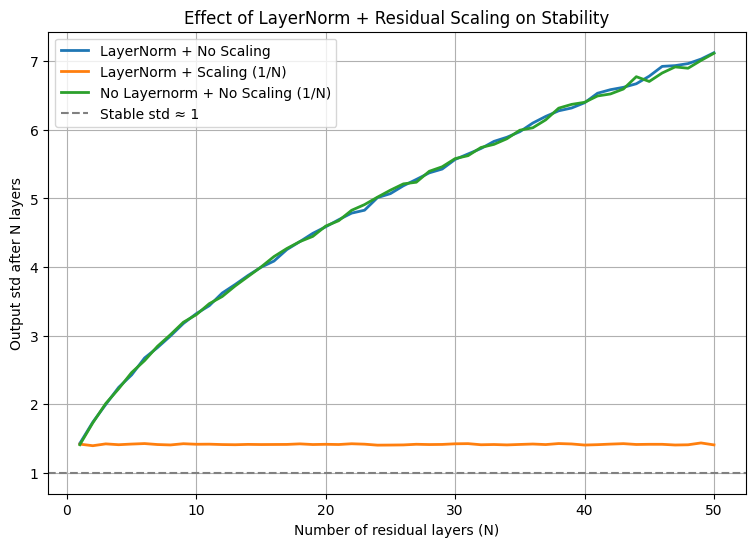

In [5]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
trials = 20000  # number of random samples per run

def simulate_with_layernorm(N, per_branch_var):
    """
    Simulate a residual stack with LayerNorm before each residual branch.
    - Input starts as N(0,1).
    - Each layer: normalize to mean=0, std=1, then add residual noise ~ N(0, per_branch_var).
    Returns the std of the final output after N layers.
    """
    x = np.random.normal(0, 1, size=(trials,))
    for _ in range(N):
        # Apply LayerNorm (normalize to mean=0, std=1 per batch)
        mean = x.mean()
        std = x.std(ddof=0)
        x_norm = (x - mean) / (std + 1e-6)

        # Residual branch contribution
        residual = np.random.normal(0, np.sqrt(per_branch_var), size=(trials,))
        x = x + residual
    return x.std(ddof=0)

def simulate_without_layernorm(N, per_branch_var):
    """
    Simulate a residual stack WITHOUT LayerNorm before each residual branch.
    - Input starts as N(0,1).
    - Each layer: directly adds residual noise ~ N(0, per_branch_var).
    Returns the std of the final output after N layers.
    """
    x = np.random.normal(0, 1, size=(trials,))
    for _ in range(N):
        # No normalization step here
        residual = np.random.normal(0, np.sqrt(per_branch_var), size=(trials,))
        x = x + residual
    return x.std(ddof=0)

# Depth range
depths = np.arange(1, 51)

# Collect results
stds_no_scale = [simulate_with_layernorm(N, 1.0) for N in depths]       # no scaling
stds_scaled   = [simulate_with_layernorm(N, 1.0 / N) for N in depths]   # scaled 1/N
stds_without_layernorm_scaled   = [simulate_without_layernorm(N, 1.0) for N in depths]   # no scaling

# Plot
plt.figure(figsize=(9,6))
plt.plot(depths, stds_no_scale, label="LayerNorm + No Scaling", linewidth=2, color="tab:blue")
plt.plot(depths, stds_scaled, label="LayerNorm + Scaling (1/N)", linewidth=2, color="tab:orange")
plt.plot(depths, stds_without_layernorm_scaled, label="No Layernorm + No Scaling (1/N)", linewidth=2, color="tab:green")
plt.axhline(1.0, color="gray", linestyle="--", label="Stable std ≈ 1")

plt.xlabel("Number of residual layers (N)")
plt.ylabel("Output std after N layers")
plt.title("Effect of LayerNorm + Residual Scaling on Stability")
plt.legend()
plt.grid(True)
plt.show()


In [2]:
import sys
sys.path.append("../src")

import settings as s
from pathlib import Path
import json
import torch
import torch.nn.functional as F 
from hellaswag import evaluate
from transformers import GPT2LMHeadModel
from utils import ModelSummary
from models import GPT

we need CUDA for DDP so falling back to CPU


In [2]:
model = GPT()
ModelSummary.summary(model)

Model size: 475.03 MB
Trainable parameters: 124.53M
Non-trainable parameters: 0


In [3]:
gpt2_model = GPT2LMHeadModel.from_pretrained(
    "gpt2", cache_dir=s.logs_path).to(s.device)
ModelSummary.summary(gpt2_model)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model size: 486.70 MB
Trainable parameters: 124.44M
Non-trainable parameters: 0


In [5]:
sd = gpt2_model.state_dict()
embedding_weights = sd["transformer.wte.weight"]
embedding_weights.shape

torch.Size([50257, 768])

## GPU cost estimation

In [1]:
100 * 0.03

3.0

In [1]:
A100_cost = ((17167 * 1.4) / 3600) * 300
A100_cost 

2002.8166666666666

In [ ]:
((17167 * 1.2) / 3600)

5.722333333333332

In [ ]:
((17167 * 3) / 3600)

14.305833333333334

In [2]:
((17167 * 2.2) / 3600)

10.490944444444445

In [9]:
A6000_cost = ((17167 * 2.2) / 3600) * 130
A6000_cost 

1363.822777777778

In [1]:
2**4

16

In [ ]:
evaluate(gpt2_xl_model)

In [ ]:
def read_jsonl(file_path):
    file_path = Path(file_path)
    with file_path.open("r", encoding="utf-8") as f:
        return [json.loads(line) for line in f if line.strip()]
    
train_data = read_jsonl(s.data_root_path / "hellaswag/hellaswag_train.jsonl")
train_data[0]

{'ind': 4,
 'activity_label': 'Removing ice from car',
 'ctx_a': 'Then, the man writes over the snow covering the window of a car, and a woman wearing winter clothes smiles.',
 'ctx_b': 'then',
 'ctx': 'Then, the man writes over the snow covering the window of a car, and a woman wearing winter clothes smiles. then',
 'split': 'train',
 'split_type': 'indomain',
 'label': 3,
 'endings': [', the man adds wax to the windshield and cuts it.',
  ', a person board a ski lift, while two men supporting the head of the person wearing winter clothes snow as the we girls sled.',
  ', the man puts on a christmas coat, knitted with netting.',
  ', the man continues removing the snow on his car.'],
 'source_id': 'activitynet~v_-1IBHYS3L-Y'}

In [ ]:
model = GPT2LMHeadModel.from_pretrained(
    "gpt2", cache_dir=s.logs_path).to(s.device)
summary = ModelSummary(model)
summary.summary()

Model size: 486.70 MB
Trainable parameters: 124.44M
Non-trainable parameters: 0


In [ ]:
def print_example(row):
    question = row["ctx"]
    options = row["endings"]
    correct_option = row["label"]

    print(question)
    for i, option in enumerate(options, start=1):
        print(f"{i}: {option}")

    print(correct_option)

row = train_data[2]
print_example(row)

A female chef in white uniform shows a stack of baking pans in a large kitchen presenting them. The pans are filled with pastries and loaded into the oven. a knife
1: is seen moving on a board and cutting out its contents.
2: hits the peeled cheesecake, followed by sliced custard and still cooked ice cream.
3: etches a shape into the inside of the baked pans.
4: is used to cut cylinder shaped dough into rounds.
3


In [ ]:
def render_example(example):
    """
    Given the example as a dictionary, render it as three torch tensors:
    - tokens (the tokens of context + completion, of size 4xN, as there are always 4 candidates)
    - mask (is 1 in the region of the candidate completion, where we evaluate likelihoods)
    - label (the index of the correct completion, which we hope has the highest likelihood)
    """
    ctx = example["ctx"]
    label = example["label"]
    endings = example["endings"]

    # data needed to reproduce this eval on the C size
    data = {
        "label": label,
        "ctx_tokens": None,
        "ending_tokens": [],
    }

    # gather up all the tokens
    ctx_tokens = s.enc.encode(ctx)
    data["ctx_tokens"] = ctx_tokens
    tok_rows = []
    mask_rows = []
    for end in endings:
        # note: prepending " " because GPT-2 tokenizer
        end_tokens = s.enc.encode(" " + end)
        tok_rows.append(ctx_tokens + end_tokens)
        mask_rows.append([0]*len(ctx_tokens) + [1]*len(end_tokens))
        data["ending_tokens"].append(end_tokens)

    # have to be careful during the collation because the number of tokens in each row can differ
    max_len = max(len(row) for row in tok_rows)
    tokens = torch.zeros((4, max_len), dtype=torch.long)
    mask = torch.zeros((4, max_len), dtype=torch.long)
    for i, (tok_row, mask_row) in enumerate(zip(tok_rows, mask_rows)):
        tokens[i, :len(tok_row)] = torch.tensor(tok_row)
        mask[i, :len(mask_row)] = torch.tensor(mask_row)

    return data, tokens, mask, label

In [ ]:
data, tokens, mask, label = render_example(train_data[2])
tokens.shape

torch.Size([4, 51])

In [ ]:
for t in tokens:
    print(s.enc.decode(t.tolist()))

for t in mask:
    print(s.enc.decode(t.tolist()))

A female chef in white uniform shows a stack of baking pans in a large kitchen presenting them. The pans are filled with pastries and loaded into the oven. a knife is seen moving on a board and cutting out its contents.!!!!!
A female chef in white uniform shows a stack of baking pans in a large kitchen presenting them. The pans are filled with pastries and loaded into the oven. a knife hits the peeled cheesecake, followed by sliced custard and still cooked ice cream.
A female chef in white uniform shows a stack of baking pans in a large kitchen presenting them. The pans are filled with pastries and loaded into the oven. a knife etches a shape into the inside of the baked pans.!!!!!
A female chef in white uniform shows a stack of baking pans in a large kitchen presenting them. The pans are filled with pastries and loaded into the oven. a knife is used to cut cylinder shaped dough into rounds.!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!""""""""""""!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!""

In [ ]:
# get the logits
tokens = tokens.to(s.device)
logits = model(tokens).logits
logits.shape

torch.Size([4, 51, 50257])

In [ ]:
x = tokens[..., :-1]
y = tokens[..., 1:]

logits = model(x).logits
logits.shape

torch.Size([4, 50, 50257])

In [ ]:
type(model(x))
2494/10042
2456/10042

transformers.modeling_outputs.CausalLMOutputWithCrossAttentions

In [ ]:
flat_logits = logits.reshape(-1, logits.shape[-1])
flat_y = y.reshape(-1)
shift_losses = F.cross_entropy(
    flat_logits, flat_y, reduction='none')

shift_losses = shift_losses.reshape(y.shape[0], -1)

# now get the average loss just for the completion region (where mask == 1), in each row
# we must shift mask, so we start at the last prompt token
shift_mask = mask[..., 1:]
masked_shift_losses = shift_losses * shift_mask

# sum and divide by the number of 1s in the mask
sum_loss = masked_shift_losses.sum(dim=1)
avg_loss = sum_loss / shift_mask.sum(dim=1)

avg_loss.shape

torch.Size([4])

In [ ]:
from hellaswag import iterate_examples, get_most_likely_row

# once in a while evaluate hellaswag
num_correct_norm = 0
num_total = 0
for i, example in enumerate(iterate_examples("val")):
    # only process examples where i % ddp_world_size == ddp_rank
    if i % s.ddp_world_size != s.ddp_local_rank:
        continue
    # render the example into tokens and labels
    _, tokens, mask, label = render_example(example)
    tokens = tokens.to(s.device)
    mask = mask.to(s.device)
    x = tokens[..., :-1]
    y = tokens[..., 1:]

    # get the logits
    with torch.no_grad():
        with torch.autocast(device_type=s.device, dtype=torch.bfloat16):
            logits = model(x).logits
        pred_norm = get_most_likely_row(logits, y, mask)
    num_total += 1
    num_correct_norm += int(pred_norm == label)

hellaswag_acc = num_correct_norm / num_total
if s.ddp_master_process:
    print(
        f"HellaSwag accuracy: {num_correct_norm}/{num_total}={hellaswag_acc:.4f}")


HellaSwag accuracy: 2962/10042=0.2950
